TODO:
- Log runtime.
- Make function that plots largest/pathological errors.
- Set up code for random search.
- Understand tensor dimensions throughout network.
- Look at LBM paper for error
- Try using scaling function instead of scaler - more flexibility.

DONE:
- Try demeaning all series? - doesn't work well.
- Why do plots have such different proportions of houses? - because three homes have data for *all* time periods.

In [38]:
from __future__ import division

from utils import *
from create_data import *
from build_models import *

import os
import pandas as pd
import numpy as np
from collections import OrderedDict
import time
from datetime import datetime, date, timedelta
from dateutil.parser import parse
import re

import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
# from ggplot import *

import keras
from keras import backend as K
from keras.models import Sequential, load_model
from keras.layers import Dense, Activation, Conv1D, MaxPooling1D, Flatten, Dropout, BatchNormalization
from keras.callbacks import EarlyStopping, CSVLogger, ModelCheckpoint, LambdaCallback
from keras.utils import plot_model
from keras import regularizers

from sklearn.utils import shuffle
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

%matplotlib inline
matplotlib.style.use('ggplot')

In [2]:
dir_proj = '/Users/sipola/Google Drive/education/coursework/graduate/edinburgh/dissertation/thesis'
dir_data = os.path.join(dir_proj, 'data')
dir_for_model = os.path.join(dir_data, 'for_model')
dir_for_model_real = os.path.join(dir_for_model, 'real')
dir_for_model_synth = os.path.join(dir_for_model, 'synthetic')
dir_models = os.path.join(dir_data, 'models')
dir_run = os.path.join(dir_proj, 'run', str(date.today()))

In [3]:
N_PER_DAY = 14400  # 24 * 60 * 60 / 6
HOUSE_IDS = range(1, 22); HOUSE_IDS.remove(14)  # no house 14
HOUSE_IDS_TEST = [2,9,20]
HOUSE_IDS_TRAIN_VAL = [house_id for house_id in HOUSE_IDS if house_id not in HOUSE_IDS_TEST]
# HOUSE_IDS_SOLAR = [3,11,21]  # according to paper
HOUSE_IDS_SOLAR = [1,11,21]  # according to inspection
HOUSE_IDS_NOT_SOLAR = [house_id for house_id in HOUSE_IDS if house_id not in HOUSE_IDS_SOLAR]
# TRAIN_VAL_DATE_MAX = date(2015,2,28)
APP_NAMES = ['fridge', 'kettle', 'washing machine', 'dishwasher', 'microwave']
TRAIN_DTS = np.load(os.path.join(dir_for_model, 'train_dts.npy'))

In [7]:
take_diff = False
# val_prop = 0.2
train_dates = [dt.date() for dt in TRAIN_DTS]
extreme_percentile_cutoff = 98

In [8]:
# In every set of data, there's a feature set X, targets Y, and extra features
# regarding house number and date that can be used to subset or diagnose.
# This data will be saved as a package according to the order below. This makes
# it easier to enter into functions like train_test_split() and shuffle() using
# *kwargs.
X_idx = 0
Y_idx = 1
x_house_idx = 2
x_date_idx = 3

Run this once

In [9]:
np.random.seed(20170627)

# Process real data.
print 'processing real data...'
all_data = OrderedDict()
all_data['real'] = list(load_real_data(dir_for_model_real))
all_data['real'] = remove_extremes(all_data['real'], extreme_percentile_cutoff, Y_idx)
all_data = remove_solar_from_real(all_data, HOUSE_IDS_SOLAR, x_house_idx)
all_data = split_real_into_train_and_valtest(all_data, HOUSE_IDS_TRAIN_VAL, train_dates,
                                             x_house_idx, x_date_idx)
all_data = split_valtest_into_val_and_test(all_data, x_house_idx)

# Process synthetic data.
print 'processing synthetic data...'
all_data['synth_train_all'] = list(load_synth_data(dir_for_model_synth))
all_data['synth_train_all'] = remove_extremes(all_data['synth_train_all'], extreme_percentile_cutoff, Y_idx)

# Want to take diffs before making scalers.
if take_diff:
    print 'taking diffs...'
    for key in all_data.keys():
        all_data[key][X_idx] = take_diff_df(all_data[key][X_idx])

# Create scalers.
print 'creating scalers...'
scaler_real, scaler_synth, scaler_both = create_scalers_for_real_synth_both(all_data, X_idx)

# Scale validation and test data.
print 'scaling validation and test data...'
for split_type in ['val', 'test']:
    all_data[split_type][X_idx] = scaler_real.transform(all_data[split_type][X_idx])
    all_data[split_type][X_idx] = scaler_both.transform(all_data[split_type][X_idx])

processing real data...
obs for train/val: 4721 (70% of total)
processing synthetic data...
creating scalers...


/Users/sipola/miniconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:429: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, _DataConversionWarning)


scaling validation and test data...


In [10]:
# Extract val/test data for easy reference.
val_data = list(all_data['val'])
test_data = list(all_data['test'])

In [11]:
# Get index of appliance to model.
app_names = ['fridge']
# app_names = list(APP_NAMES)
app_idx = []
for app_name in app_names:
    app_idx.append(APP_NAMES.index(app_name))

In [388]:
# model_name = 'pilot_model_tmp'

def create_model(
    num_outputs,
    num_conv_layers,
    num_dense_layers,
    start_filters,
    deepen_filters,
    kernel_size,
    strides,
    dilation_rate,
    do_pool,
    pool_size,
    last_dense_layer_size,
    dropout_rate_after_conv,
    dropout_rate_after_dense,
    use_batch_norm,
    optimizer,
    learning_rate,
    l2_penalty
):
    
    if dilation_rate > 1:
        # Make dilation rate override stride length.
        strides = 1
    
    if not do_pool:
        pool_size = None
        
    if num_dense_layers == 0:
        last_dense_layer_size == None
        
    assert not (dilation_rate != 1 and strides != 1)

    kernel_regularizer = regularizers.l2(l2_penalty)
    input_shape = (N_PER_DAY, 1) if K.image_data_format() == 'channels_last' else (1, N_PER_DAY)

    model = Sequential()
    
    # Add convolutional layers.
    for layer_num in range(num_conv_layers):
        
        filter_multiplier = 2**layer_num if deepen_filters else 1
        filters = start_filters * filter_multiplier
        
        conv_args = {'filters': filters,
                     'kernel_size': kernel_size,
                     'strides': strides,
                     'padding': 'same',
                     'dilation_rate': dilation_rate,
                     'activation': 'relu',
                     'name': 'conv_{}'.format(layer_num),
                     'kernel_regularizer': kernel_regularizer}
        if layer_num == 0:
            # Need input shape if first layer.
            conv_args['input_shape'] = input_shape
        
        model.add(Conv1D(**conv_args))
        
        if do_pool:
            model.add(MaxPooling1D(pool_size, padding='same', name='pool_{}'.format(layer_num)))
    
    model.add(Dropout(dropout_rate_after_conv, name='dropout_after_conv'))
    model.add(Flatten(name='flatten'))
    
    # Add dense layers.
    for layer_num in range(num_dense_layers):
        layer_size = last_dense_layer_size * 2**(num_dense_layers - layer_num - 1)
        model.add(Dense(layer_size, activation='relu',
                        kernel_regularizer=kernel_regularizer, name='dense_{}'.format(layer_num)))
        model.add(Dropout(dropout_rate_after_dense, name='dropout_dense_{}'.format(layer_num)))
        if use_batch_norm:
            model.add(BatchNormalization(name='batch_norm_{}'.format(layer_num)))
    
    model.add(Dense(len(app_names), activation='softplus', name='dense_output',
                    kernel_regularizer=kernel_regularizer))
    
    model.compile(loss='mean_squared_error',
                  # optimizer='adam',
                  optimizer = optimizer(lr=learning_rate),
                  metrics=['mape'])
    
    return model

In [17]:
batch_size = 32
real_to_synth_ratio = 0.5

In [18]:
generator = generate_data((all_data['real_train'][X_idx], all_data['real_train'][Y_idx][:,app_idx]),
                          (all_data['synth_train_all'][X_idx], all_data['synth_train_all'][Y_idx][:,app_idx]),
                          scaler_real, scaler_synth, scaler_both,
                          batch_size = batch_size,
                          real_to_synth_ratio = real_to_synth_ratio)

In [ ]:
generator2 = generate_data((all_data['real_train'][X_idx][:100], all_data['real_train'][Y_idx][:,app_idx][:100]),
                           (all_data['synth_train_all'][X_idx][:1000], all_data['synth_train_all'][Y_idx][:,app_idx][:1000]),
                           scaler_real, scaler_synth, scaler_both,
                           batch_size = batch_size,
                           real_to_synth_ratio = real_to_synth_ratio)

In [ ]:
generator2 = generate_data(use_saved=True,
                           save_dir=dir_for_model,
                           batch_size=batch_size,
                           real_to_synth_ratio=real_to_synth_ratio)

In [19]:
_ = generator.next()  # optional; just initializes the generator

shuffling...
scaling real data...
scaling synthetic data...
scaling real and synthetic data jointly...


In [317]:
# params = {
#     'num_conv_layers': 2,
#     'num_dense_layers': 1,
#     'start_filters': 8,
#     'kernel_size': 6,
#     'strides': 2,
#     'dilation_rate': 1,
#     'do_pool': True,
#     'pool_size': 2,
#     'last_dense_layer_size': 256,
#     'dropout_rate_after_conv': 0.25,
#     'dropout_rate_after_dense': 0.5,
#     'use_batch_norm': False,
#     'optimizer': keras.optimizers.Adam,
#     'learning_rate': 0.001,
#     'l2_penalty': 0
# }
    
params = random_params()
model = create_model(app_names, **params)

{'optimizer': <class 'keras.optimizers.Adagrad'>, 'num_dense_layers': 2, 'learning_rate': 0.003, 'last_dense_layer_size': 32, 'strides': 2, 'use_batch_norm': False, 'dropout_rate_after_conv': 0.0, 'do_pool': False, 'num_conv_layers': 3, 'pool_size': 2, 'dropout_rate_after_dense': 0.0, 'dilation_rate': 3, 'start_filters': 4, 'l2_penalty': 0, 'kernel_size': 3}
64
32


In [48]:
# plot_model(model)  # https://keras.io/visualization/

In [265]:
today_str = str(date.today())

model_0
                                                           0
optimizer                 <class 'keras.optimizers.RMSprop'>
num_dense_layers                                           0
do_pool                                                False
num_conv_layers                                            2
learning_rate                                         0.0003
last_dense_layer_size                                     32
deepen_filters                                          True
dropout_rate_after_dense                                0.25
pool_size                                                  2
strides                                                    2
dilation_rate                                              1
start_filters                                              4
use_batch_norm                                         False
l2_penalty                                                 0
dropout_rate_after_conv                                  0.1
kernel_size     

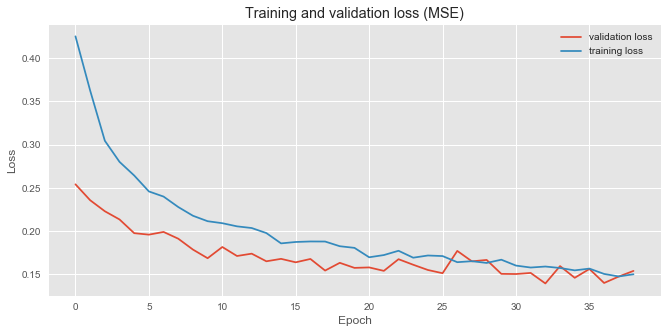

model_3
                                                           0
optimizer                 <class 'keras.optimizers.Adagrad'>
num_dense_layers                                           2
do_pool                                                False
num_conv_layers                                            1
learning_rate                                          0.001
last_dense_layer_size                                     32
deepen_filters                                         False
dropout_rate_after_dense                                0.25
pool_size                                                  2
strides                                                    3
dilation_rate                                              1
start_filters                                              4
use_batch_norm                                         False
l2_penalty                                                 0
dropout_rate_after_conv                                  0.5
kernel_size     

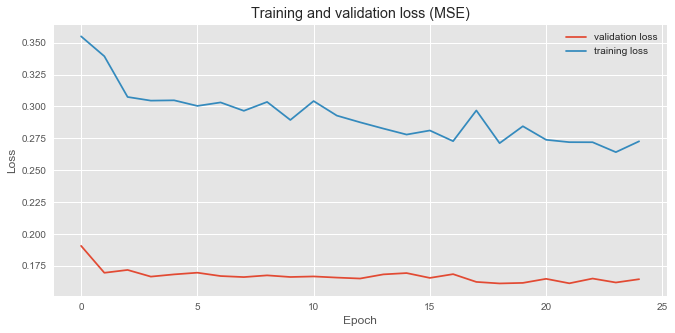

model_4
                                                           0
optimizer                 <class 'keras.optimizers.Adagrad'>
num_dense_layers                                           0
do_pool                                                 True
num_conv_layers                                            2
learning_rate                                          0.001
last_dense_layer_size                                      8
deepen_filters                                          True
dropout_rate_after_dense                                 0.5
pool_size                                                  4
strides                                                    2
dilation_rate                                              1
start_filters                                              2
use_batch_norm                                         False
l2_penalty                                             0.001
dropout_rate_after_conv                                  0.1
kernel_size     

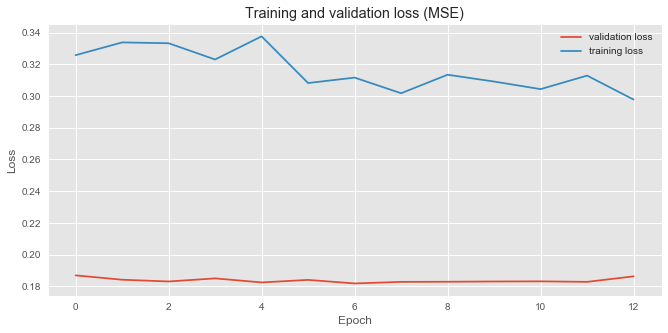

model_5
                                                           0
optimizer                 <class 'keras.optimizers.Adagrad'>
num_dense_layers                                           1
do_pool                                                 True
num_conv_layers                                            2
learning_rate                                          0.001
last_dense_layer_size                                     16
deepen_filters                                         False
dropout_rate_after_dense                                   0
pool_size                                                  2
strides                                                    1
dilation_rate                                              1
start_filters                                              4
use_batch_norm                                          True
l2_penalty                                                 0
dropout_rate_after_conv                                 0.25
kernel_size     

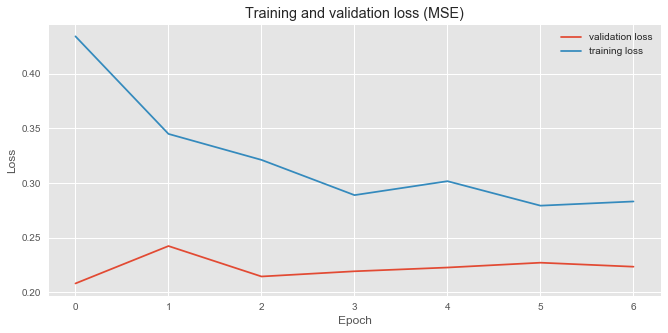

model_6
                                                           0
optimizer                 <class 'keras.optimizers.Adagrad'>
num_dense_layers                                           2
do_pool                                                 True
num_conv_layers                                            3
learning_rate                                          0.001
last_dense_layer_size                                     32
deepen_filters                                         False
dropout_rate_after_dense                                 0.1
pool_size                                                  4
strides                                                    2
dilation_rate                                              1
start_filters                                              4
use_batch_norm                                         False
l2_penalty                                                 0
dropout_rate_after_conv                                  0.5
kernel_size     

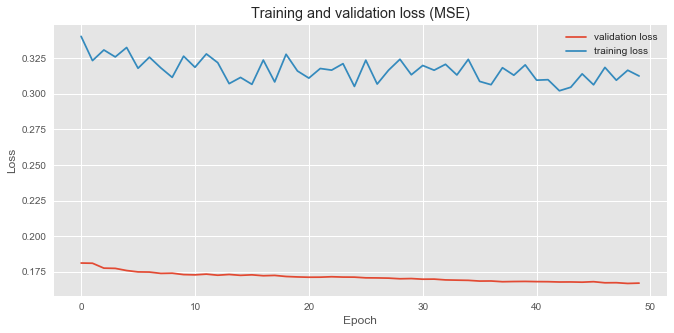

model_7
                                                           0
optimizer                 <class 'keras.optimizers.Adagrad'>
num_dense_layers                                           2
do_pool                                                 True
num_conv_layers                                            3
learning_rate                                         0.0001
last_dense_layer_size                                      8
deepen_filters                                         False
dropout_rate_after_dense                                 0.5
pool_size                                                  4
strides                                                    3
dilation_rate                                              1
start_filters                                              2
use_batch_norm                                          True
l2_penalty                                                 0
dropout_rate_after_conv                                    0
kernel_size     

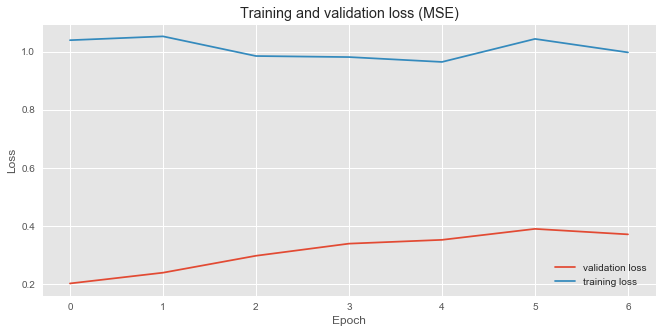

model_8
                                                        0
optimizer                 <class 'keras.optimizers.Adam'>
num_dense_layers                                        2
do_pool                                              True
num_conv_layers                                         3
learning_rate                                      0.0003
last_dense_layer_size                                  32
deepen_filters                                      False
dropout_rate_after_dense                              0.1
pool_size                                               2
strides                                                 1
dilation_rate                                           1
start_filters                                           2
use_batch_norm                                       True
l2_penalty                                              0
dropout_rate_after_conv                                 0
kernel_size                                             6


Epoc

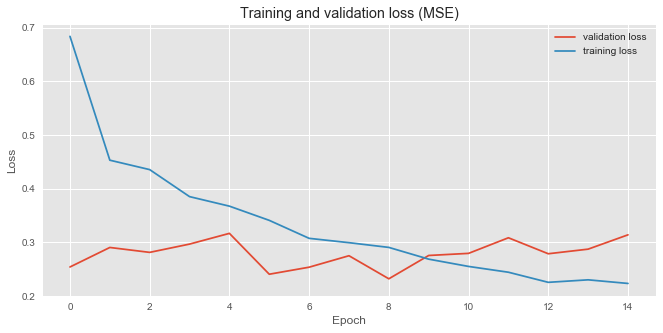

model_9
                                                           0
optimizer                 <class 'keras.optimizers.Adagrad'>
num_dense_layers                                           2
do_pool                                                False
num_conv_layers                                            2
learning_rate                                         0.0003
last_dense_layer_size                                     16
deepen_filters                                         False
dropout_rate_after_dense                                 0.5
pool_size                                                  2
strides                                                    2
dilation_rate                                              1
start_filters                                              8
use_batch_norm                                         False
l2_penalty                                                 0
dropout_rate_after_conv                                    0
kernel_size     

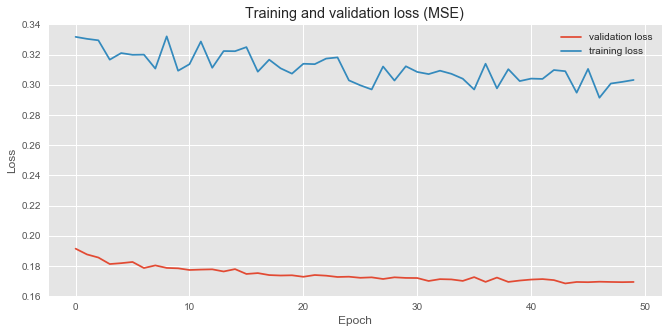

model_10
                                                           0
optimizer                 <class 'keras.optimizers.RMSprop'>
num_dense_layers                                           1
do_pool                                                 True
num_conv_layers                                            2
learning_rate                                         0.0003
last_dense_layer_size                                     32
deepen_filters                                         False
dropout_rate_after_dense                                 0.1
pool_size                                                  4
strides                                                    2
dilation_rate                                              1
start_filters                                              2
use_batch_norm                                         False
l2_penalty                                                 0
dropout_rate_after_conv                                    0
kernel_size    

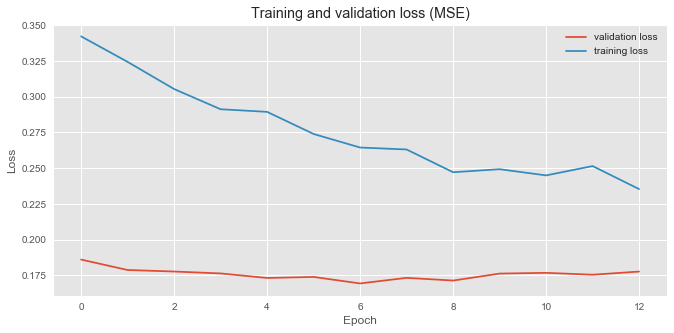

model_11
                                                        0
optimizer                 <class 'keras.optimizers.Adam'>
num_dense_layers                                        2
do_pool                                              True
num_conv_layers                                         3
learning_rate                                       0.001
last_dense_layer_size                                  16
deepen_filters                                       True
dropout_rate_after_dense                              0.5
pool_size                                               2
strides                                                 2
dilation_rate                                           1
start_filters                                           2
use_batch_norm                                      False
l2_penalty                                              0
dropout_rate_after_conv                              0.25
kernel_size                                             6


Epo

In [ ]:
continue_from_last_run = False
models_to_run = 50
epochs = 50
total_obs_per_epoch = 4096
# total_obs_per_epoch = 256

steps_per_epoch = total_obs_per_epoch // batch_size
dir_models_set = os.path.join(dir_models, today_str, app_names_to_filename(app_names))

# "Append" results to last runs of models, if they exist?
if continue_from_last_run:
    # Get max model number.
    model_files = os.listdir(dir_models_set)
    max_model_num = -1
    for model_file in model_files:
        try:
            max_model_num = max(int(re.sub('model_', '', model_file)), max_model_num)
        except ValueError:
            pass
    max_model_num += 1
else:
    max_model_num = 0

for model_num in np.arange(models_to_run) + max_model_num:
    
    model_name = 'model_{}'.format(model_num)
    print '='*25 + '\n{}\n'.format(model_name) + '='*25

    params = random_params()
    
    print pd.DataFrame.from_dict(params, orient='index')
    print '\n' + '='*25 + '\n'
    
    model = create_model(app_names, **params)
    
    dir_this_model = os.path.join(dir_models_set, model_name)
    model_filename = os.path.join(dir_this_model, 'weights.hdf5')
    history_filename = os.path.join(dir_this_model, 'history.csv')
    params_filename = os.path.join(dir_this_model, 'params.csv')
    makedirs2(dir_this_model)

    pd.DataFrame.from_dict(params, orient='index').to_csv(params_filename, header=False)

    # Define callbacks
    # https://keras.io/callbacks
    early_stopping = EarlyStopping(monitor='val_loss', patience=5)
    csvlogger = CSVLogger(history_filename, separator=',', append=False)
    checkpointer = ModelCheckpoint(filepath=model_filename, verbose=1, save_best_only=True)
    runtime_history = RuntimeHistory()

    history = model.fit_generator(generator,
                                  steps_per_epoch = steps_per_epoch,
                                  epochs = epochs,
                                  validation_data=(reshape_as_tensor(all_data['val'][X_idx]),
                                                   all_data['val'][Y_idx][:,app_idx]),
                                  callbacks = [early_stopping, csvlogger, checkpointer, runtime_history])

    # Add runtimes to CSV.
    history_df = pd.read_csv(history_filename)
    history_df['runtime'] = runtime_history.runtime
    history_df.to_csv(history_filename, index=False)

    # Load best model.
    model_filename = os.path.join(dir_this_model, 'weights.hdf5')
    model = load_model(model_filename)
    
    plot_errors(history_df)
    plt.show()

In [370]:
dir_models_set = os.path.join(dir_models, today_str, app_names_to_filename(app_names))
model_files = get_model_files(dir_models_set)

history_all = []
params_all = []

for model_name in model_files:
    
    history_df = pd.read_csv(os.path.join(dir_models_set, model_name, 'history.csv'))
    params_df = pd.read_csv(os.path.join(dir_models_set, model_name, 'params.csv'),
                            header=None,
                            names=['param', 'value'])
    
    history_df['model'] = model_name
    params_df['model'] = model_name    
    
    history_all.append(history_df)
    params_all.append(params_df)
    
    # print model_name
    # print params_df

    # plot_errors(history_df, figsize=(11,5))
    # plt.show()
    
params_all = pd.concat(params_all)
history_all = pd.concat(history_all)

# print all_history
params_wide = params_all.pivot(index='model', columns='param')
history_best = history_all.groupby('model').agg({
    'loss': min,
    'val_loss': min,
    'runtime': min,
    'epoch': lambda x: len(x)
})

hist_and_params = history_best.join(params_wide)

hist_and_params.sort_values('val_loss', inplace=True)
hist_and_params

# print params_all

loss  epoch    runtime  val_loss  \
model                                                      
pilot_model_simple  0.233535      8  20.796345  0.168870   
model_7             0.287189      5   3.361214  0.172662   
model_5             0.283132      5   7.782211  0.176964   
model_10            0.358272      5   2.141726  0.215465   
model_1             0.340726      5   8.586450  0.218070   
model_6             0.389531      5  18.030267  0.227468   
model_2             0.431106      5   1.769573  0.291142   
model_8             0.377682      5  74.177272  0.298325   
model_11            0.363273      5   2.120445  0.308134   
model_9             0.624568      5   0.814572  0.458671   
model_3             0.923744      5   1.283484  0.890418   
model_12            0.857637      5   2.749870  0.896798   
model_0             1.405265      5  23.076488  1.193205   
model_4             4.511972      5   7.520468  3.938289   

                   (value, dilation_rate) (value, do_pool)  \
model                                                        
pilot_model_simple                      0             True   
model_7                                 1            False   
model_5                                 1             True   
model_10                                1            False   
model_1                                 1            False   
model_6                                 3            False   
model_2                                 1            False   
model_8                                 1            False   
model_11                                3             True   
model_9                                 1             True   
model_3                                 1             True   
model_12                                1            False   
model_0                                 3             True   
model_4                                 1            False   

                   (value, dropout_rate_after_conv)  \
model                                                 
pilot_model_simple              0.10000000000000001   
model_7                         0.10000000000000001   
model_5                                        0.25   
model_10                                       0.25   
model_1                         0.10000000000000001   
model_6                                        0.25   
model_2                                         0.0   
model_8                                        0.25   
model_11                                       0.25   
model_9                                         0.0   
model_3                         0.10000000000000001   
model_12                                       0.25   
model_0                         0.10000000000000001   
model_4                                         0.5   

                   (value, dropout_rate_after_dense) (value, kernel_size)  \
model                                                                       
pilot_model_simple                              0.25                   12   
model_7                          0.10000000000000001                   12   
model_5                                         0.25                    6   
model_10                         0.10000000000000001                    6   
model_1                                         0.25                    3   
model_6                                         0.25                    3   
model_2                          0.10000000000000001                    3   
model_8                                          0.5                    6   
model_11                         0.10000000000000001                    6   
model_9                                         0.25                    6   
model_3                                         0.25                    6   
model_12                                         0.0                    3   
model_0                                          0.5                   24   
model_4                           

In [51]:
app_idx2 = 0
y_val = val_data[Y_idx][:,app_idx2]
y_hat = model.predict(reshape_as_tensor(val_data[X_idx]))[:,app_idx2]
if all(y_hat[0] == y_hat):
    print 'all predicted values are the same!'

all predicted values are the same!


In [227]:
# plot_series(val_data[X_idx][1])

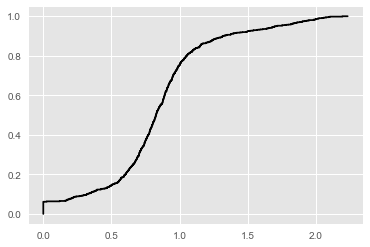

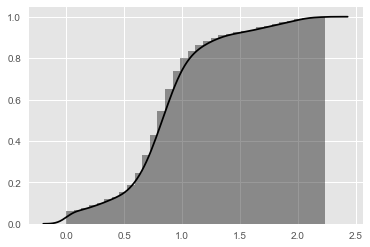

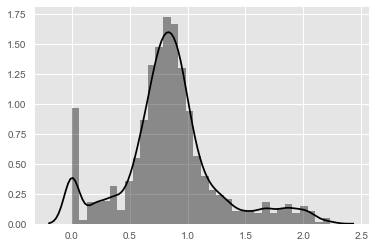

In [52]:
# sns.distplot(np.log2(y+1))
# sns.distplot(y, color='black')
plot_empir_cum(y_val)
plt.show()
sns.distplot(y_val, color='black', hist_kws={'cumulative': True}, kde_kws={'cumulative': True})
plt.show()
sns.distplot(y_val, color='black')
plt.show()

# for i in range(Y.shape[1]):
#     ax = sns.distplot(Y[:,i], color='black')
#     ax.set_title('{}, actual'.format(APP_NAMES[i]))
#     plt.show()
#     ax = sns.distplot(Y_hat[:,i], color='black')
#     ax.set_title('{}, predicted'.format(APP_NAMES[i]))
#     plt.show() 

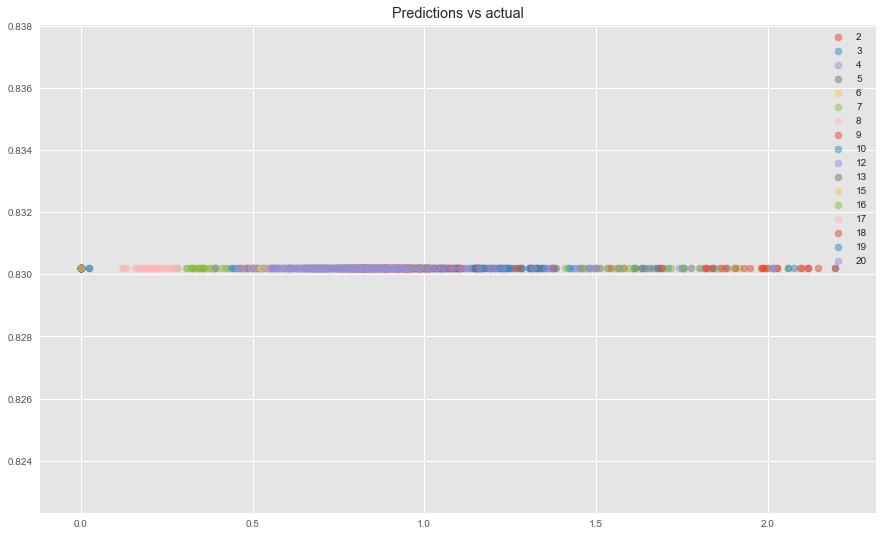

In [52]:
# # y_hat = dist_fun(y_hat, min_y, True)
# ax = sns.regplot(x=array_to_1d(y), y=array_to_1d(y_hat), color='black')
# ax.set_ylim(0,5)
# ax.set_xlim(0,5)

# colormap = plt.cm.Set1

x_house_val = val_data[x_house_idx]

plot_together = True
figsize = (15,9)
plt_title = 'Predictions vs actual'
if plot_together:
    fig = plt.figure(figsize=figsize)
    ax = fig.add_subplot(111, title=plt_title)
# ax.set_color_cycle([colormap(i) for i in np.linspace(0, 1, len(app_names))])
for house_id in list(set(x_house_val)):
    if not plot_together:
        fig = plt.figure(figsize=figsize)
        ax = fig.add_subplot(111, title=plt_title + '\nHouse {}'.format(house_id))
    y_hat_house = y_hat[x_house_val==house_id]
    y_val_house = y_val[x_house_val==house_id]
    ax.scatter(y_val_house, y_hat_house, alpha=0.5, label=house_id)
# plt.show()
# ax.set_ylim(0,2)
# ax.set_xlim(0,5)
ax.legend()
plt.show()
# print min(y_hat)


# i = 3
# y, y_hat = Y[:,i], Y_hat[:,i]
# fig = plt.figure()
# ax = fig.add_subplot(111, title='Test scatter')
# ax.scatter(y_hat, y, color='black', alpha=0.5)
# ax.set_ylim(0,5)
# ax.set_xlim(0,5)
# # print min(y_hat)

num extreme predictions: 4
extreme prediction 0
actual energy: [ 0.395835], predicted: [ 11.80590725]


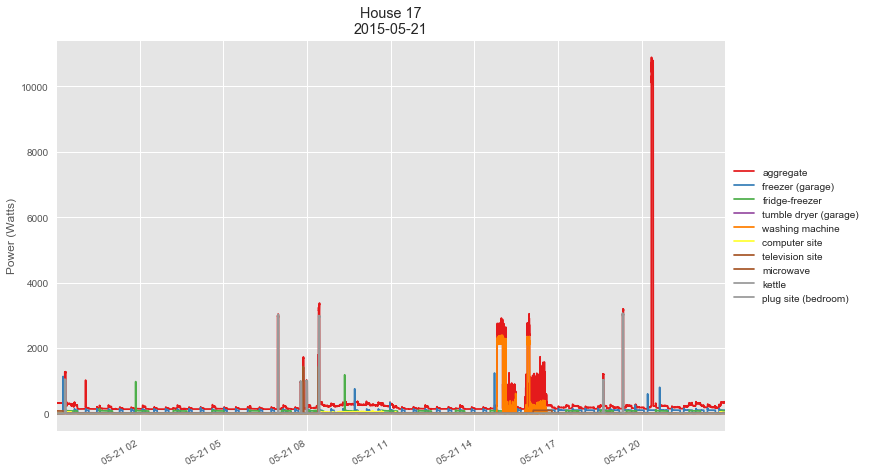

In [120]:
# Check where targets were normal but predictions were extreme.
extreme_y_hat_cutoff = 10

bad_idx = np.where(y_hat > extreme_y_hat_cutoff)[0]
print 'num extreme predictions: {}'.format(len(bad_idx))

i = 0  # change this
print 'extreme prediction {}'.format(i)

house_id = val_data[x_house_idx][bad_idx][i]
d = val_data[x_date_idx][bad_idx][i]
energy = val_data[Y_idx][:,app_idx][bad_idx][i]
print 'actual energy: {}, predicted: {}'.format(energy, y_hat[bad_idx][i])

plot_day(house_id, date_to_datetime(d), figsize=(15,8))

num extreme predictions: 2
extreme prediction 1
actual energy: [ 14.247415], predicted: [ 0.66881663]


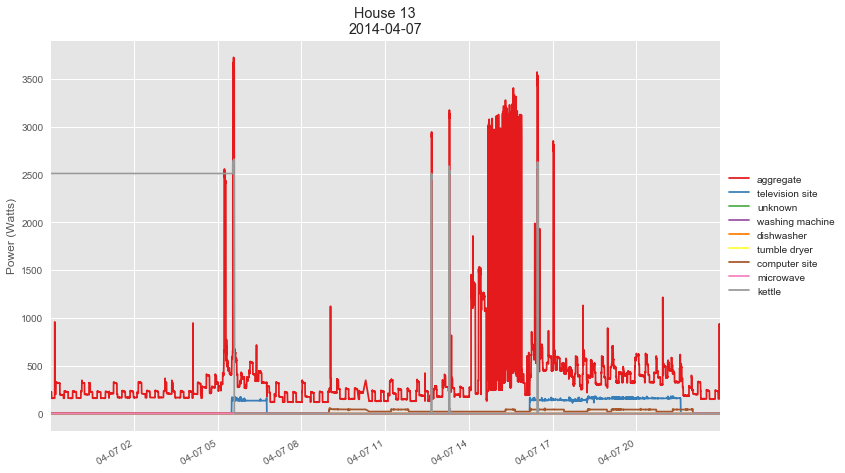

In [125]:
# Check where targets were extreme but predictions were too low.
extreme_y_cutoff = 2

bad_idx = np.where(y_val > extreme_y_cutoff)[0]
print 'num extreme predictions: {}'.format(len(bad_idx))

i = 1  # change this
print 'extreme prediction {}'.format(i)

house_id = val_data[x_house_idx][bad_idx][i]
d = val_data[x_date_idx][bad_idx][i]
energy = val_data[Y_idx][:,app_idx][bad_idx][i]
print 'actual energy: {}, predicted: {}'.format(energy, y_hat[bad_idx][i])

plot_day(house_id, date_to_datetime(d), figsize=(15,8))

In [ ]:
dir_refit_csv = os.path.join(dir_data, 'CLEAN_REFIT_081116')
dir_refit = os.path.join(dir_data, 'refit')
apps = pd.read_csv(os.path.join(dir_data, 'appliances.csv'))
app_dict = create_app_dict()
apps = apps_add_cols_from_patterns(apps, app_dict)
get_house_app_tuples, get_app_nums, get_app_name, is_a_target_app = create_app_funs(apps, app_dict, APP_NAMES)
load_app, load_ts, load_issues = create_load_funs(dir_refit)

path_daily_stats = os.path.join(dir_data, 'stats_by_day.pkl')
dstats = pd.read_pickle(path_daily_stats)
dstats = clean_daily_stats(dstats)

def get_df(house_id, use_app_names=False, dt_start=None, dt_end=None, include_issues=False):
    '''
    Plot time series of power data for each appliance, for specified house and date(time).
    '''
    
    # Load time series for house and get timestamps for specified date.
    ts_series = load_ts(house_id)
    
    # Add first column to df (timestamp).
    df = pd.DataFrame({'Unix': ts_series})
    
    # Add appliance columns.
    for app_num in range(10):
        if use_app_names:
            app_name = get_app_name(house_id, app_num)
        else:
            app_name = 'Appliance{}'.format(app_num) if app_num>0 else 'Aggregate'
        df[app_name] = load_app(house_id, app_num)
        
    if dt_start is not None:  # that is, if we don't want all dates
        ts_mask = get_ts_mask(ts_series, dt_start, dt_end)
        df = df.loc[ts_mask]
    
    if include_issues:
        # Add issues column.
        df['Issues'] = load_issues(house_id)
    
    return df


def plot_day(house_id, dt, savefile=None, figsize=(9,5), cols=None):
    '''
    Plot time series of power data for each appliance, for specified house and date(time).
    '''
    df = get_df(house_id, use_app_names=True, dt_start=dt)
    if cols is not None:
        cols += ['Unix']  # add Unix in case it wasn't included in cols
        cols = list(set(cols))
        df = df[cols]
    df['Time'] = pd.to_datetime(df['Unix'], unit='s', utc=True)
    df.set_index('Time', inplace=True)
    del df['Unix']
    
    # df = df.tz_localize('GMT').tz_convert('Europe/London')
    fig = plt.figure()
    ax = fig.add_subplot(111)
    app_names = list(df)  # get columns from DataFrame
   
    # Set color map.
    colormap = plt.cm.Set1
    ax.set_color_cycle([colormap(i) for i in np.linspace(0, 1, len(app_names))])
    # ax = df.plot(figsize=figsize)
    for app_name in app_names:
        ax = df[app_name].plot(figsize=figsize)
    ax.set_title('House {}\n{}'.format(house_id, dt.date().strftime('%Y-%m-%d')))
    ax.set_xlabel('')
    ax.set_ylabel('Power (Watts)')
    # plt.xticks(np.arange(min(df.index), max(df.index)+1, 8.))

    # Put legend outside of plot.
    # https://stackoverflow.com/a/4701285/4794432
    box = ax.get_position()
    ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

    # # Decrese legend font size.
    # fontP = FontProperties()
    # fontP.set_size('xx-small')

    if savefile is not None:
        plt.savefig(savefile)
    return ax

In [ ]:
# val_data[X_idx][0]
i = 21
app_name = 'washing machine'

app_idx = APP_NAMES.index(app_name)

plot_series(val_data[X_idx][i])
house_id = val_data[x_house_idx][i]
d = val_data[x_date_idx][i]
energy1 = val_data[Y_idx][i][app_idx]
print house_id, d, energy1

plot_day(house_id, date_to_datetime(d))
energy2 = get_energy(dstats, house_id, d, get_app_nums(house_id, app_name))
print energy2